In [ ]:
import math
import numpy as np
from numba import cuda, jit, int32, int64
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib

In [ ]:
def cpu_vec_sum(a): return(sum(a))

@cuda.jit
def dev_vec_sum(a,c):
  i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x

  if i+1 <= len(a)/2:
    sum = 0
    sum += a[i]+a[-i-1]
    cuda.atomic.add(c, 0, sum)

    
def DeviceHost(a, c, blocks, TPB):
    dev_a = cuda.to_device(a)
    dev_c = cuda.to_device(c)
    start = datetime.now()
    dev_vec_sum[blocks, TPB](dev_a,dev_c)
    time = (datetime.now()-start)
    return (dev_c.copy_to_host(), time)

In [ ]:
def main(min, max,step):
  CPU_time = []
  CPU_res = []
  GPU_time_with_copy = []
  GPU_time_only_computing = []
  GPU_res = []
  lenght = []

  for current in range (min, max+1,step):
    a = []
    for element in range (current):
      a.append(element)

    lenght.append(len(a))
    startCPU = datetime.now()
    CPU_res.append(cpu_vec_sum(a))
    time_cpu = (datetime.now()-startCPU)
    CPU_time.append(time_cpu.total_seconds()) 

    c = np.zeros(1, dtype = np.int64)
    helper = 0
    if len(a) % 2 != 0:
      helper = a[-1]
      a.pop()
    TPB = 32
    if len(a) < 64:
      TPB = 16
      if len(a) < 32:
        TPB = 8
        if len(a) < 16:
          TPB = 4
          if len(a) < 8:
            TPB = 2
    blocks = math.ceil((len(a)/2)/TPB)

    startGPU = datetime.now()
    res, time = DeviceHost(a,c, blocks, TPB)
    time_tmp = (datetime.now()-startGPU)
    GPU_time_with_copy.append(time_tmp.total_seconds())
    GPU_res.append(res+helper)
    GPU_time_only_computing.append(time.total_seconds())
    print("Lenght of vec: ", current)
    print("Time of execution on CPU: ", CPU_time[-1])
    print("Result on CPU: ", CPU_res[-1])
    print("Time of execution on GPU: ", GPU_time_with_copy[-1])
    print("Time of computing on GPU without copy: ", GPU_time_only_computing[-1])
    print("Result on GPU: ", GPU_res[-1][0])
    print()
  return(lenght, GPU_time_with_copy, GPU_time_only_computing, GPU_res, CPU_time, CPU_res)

In [ ]:
lenght, GPU_time_wc, GPU_time_oc, GPU_res, CPU_time, CPU_res = main(1000,1000000, 1000)

Выходные данные были обрезаны до нескольких последних строк (5000).
Result on GPU:  40897857000

Lenght of vec:  287000
Time of execution on CPU:  0.001838
Result on CPU:  41184356500
Time of execution on GPU:  0.027191
Time of computing on GPU without copy:  0.001037
Result on GPU:  41184356500

Lenght of vec:  288000
Time of execution on CPU:  0.001871
Result on CPU:  41471856000
Time of execution on GPU:  0.023206
Time of computing on GPU without copy:  0.001106
Result on GPU:  41471856000

Lenght of vec:  289000
Time of execution on CPU:  0.0018
Result on CPU:  41760355500
Time of execution on GPU:  0.027819
Time of computing on GPU without copy:  0.001083
Result on GPU:  41760355500

Lenght of vec:  290000
Time of execution on CPU:  0.002861
Result on CPU:  42049855000
Time of execution on GPU:  0.0239
Time of computing on GPU without copy:  0.00058
Result on GPU:  42049855000

Lenght of vec:  291000
Time of execution on CPU:  0.002808
Result on CPU:  42340354500
Time of execution

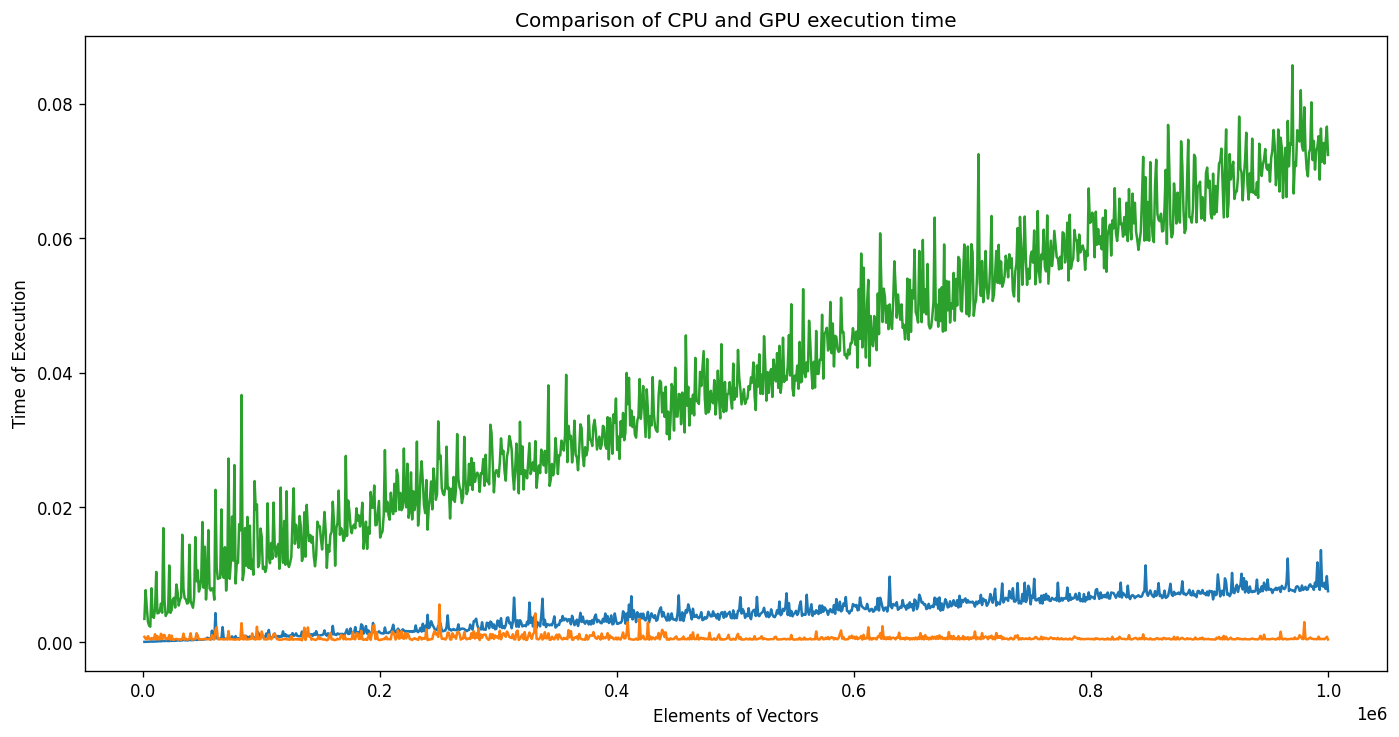

In [ ]:
 fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(14, 7), dpi=120)

plt.xlabel("Elements of Vectors")
plt.ylabel("Time of Execution")
plt.title("Comparison of CPU and GPU execution time")
ax1.plot(lenght, CPU_time)
ax1.plot(lenght,GPU_time_oc)
ax1.plot(lenght,GPU_time_wc)